In [1]:
from sqlalchemy import create_engine
import api_keys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [10]:
DB_USER = api_keys.DB_USER
DB_PASS = api_keys.DB_PASS
DB_URL = api_keys.DB_URL

engine = create_engine("mysql+pymysql://{0}:{1}@{2}".format(DB_USER, DB_PASS, DB_URL), echo=True) 
connection = engine.connect()

statement = """SELECT dayname(availability.time_queried) as dayquery, hour(availability.time_queried) as hourquery, available_bikes,temp,wind_speed,pressure,humidity,weather_main FROM dublin_bikes.availability, dublin_bikes.weather_current
where availability.number = 2 && weather_current.station_number = 2 && timestampdiff(MINUTE,availability.time_queried, weather_current.time_queried) < 5 && timestampdiff(MINUTE,availability.time_queried, weather_current.time_queried) > 0
order by availability.time_queried;
""" # create select statement for stations table

2021-03-30 09:03:10,877 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-03-30 09:03:10,883 INFO sqlalchemy.engine.base.Engine {}
2021-03-30 09:03:11,026 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-03-30 09:03:11,028 INFO sqlalchemy.engine.base.Engine {}
2021-03-30 09:03:11,319 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-03-30 09:03:11,321 INFO sqlalchemy.engine.base.Engine {}
2021-03-30 09:03:11,585 INFO sqlalchemy.engine.base.Engine show collation where `Charset` = 'utf8mb4' and `Collation` = 'utf8mb4_bin'
2021-03-30 09:03:11,588 INFO sqlalchemy.engine.base.Engine {}
2021-03-30 09:03:11,727 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-03-30 09:03:11,729 INFO sqlalchemy.engine.base.Engine {}
2021-03-30 09:03:11,863 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-03-30 09:03:11,865 INFO sqlalchemy.engine.base.E

In [15]:
df = pd.read_sql_query(statement, engine) # https://stackoverflow.com/questions/29525808/sqlalchemy-orm-conversion-to-pandas-dataframe

2021-03-30 09:03:41,833 INFO sqlalchemy.engine.base.Engine SELECT dayname(availability.time_queried) as dayquery, hour(availability.time_queried) as hourquery, available_bikes,temp,wind_speed,pressure,humidity,weather_main FROM dublin_bikes.availability, dublin_bikes.weather_current
where availability.number = 2 && weather_current.station_number = 2 && timestampdiff(MINUTE,availability.time_queried, weather_current.time_queried) < 5 && timestampdiff(MINUTE,availability.time_queried, weather_current.time_queried) > 0
order by availability.time_queried;

2021-03-30 09:03:41,834 INFO sqlalchemy.engine.base.Engine {}


In [13]:
len(df["temp"])

6457

In [16]:
df.head(5)

,dayquery,hourquery,available_bikes,temp,wind_speed,pressure,humidity,weather_main
0,Thursday,17,10,282,3,1029,66.0,Clouds
1,Thursday,17,10,281,3,1029,66.0,Clouds
2,Thursday,17,9,281,3,1029,66.0,Clouds
3,Thursday,17,9,281,3,1029,66.0,Clouds
4,Thursday,17,9,281,4,1029,66.0,Clouds


In [8]:
df.dtypes

Unnamed: 0           int64
dayquery            object
hourquery            int64
available_bikes      int64
temp                 int64
wind_speed           int64
pressure             int64
humidity           float64
weather_main        object
dtype: object

In [18]:
df.shape

(6457, 8)

In [19]:
categorical_columns = df[['dayquery', 'hourquery', 'weather_main','dayquery', 'hourquery']].columns
# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category')  

continuous_columns = df.select_dtypes(['int64']).columns
datetime_columns = df.select_dtypes(['datetime64[ns]']).columns
df["humidity"] = df["humidity"].fillna(0)
df.dtypes

dayquery           category
hourquery          category
available_bikes       int64
temp                  int64
wind_speed            int64
pressure              int64
humidity            float64
weather_main       category
dtype: object

In [20]:
df.corr()

,available_bikes,temp,wind_speed,pressure,humidity
available_bikes,1.000000,-0.025430,-0.132121,0.219883,0.295613
temp,-0.025430,1.000000,0.408661,-0.072711,-0.308244
wind_speed,-0.132121,0.408661,1.000000,-0.686403,-0.440770
pressure,0.219883,-0.072711,-0.686403,1.000000,0.410635
humidity,0.295613,-0.308244,-0.440770,0.410635,1.000000


In [21]:
weather_dummies = pd.get_dummies(df['weather_main'], prefix='weather_main', drop_first=False)
day_dummies = pd.get_dummies(df['dayquery'], prefix='dayquery', drop_first=False)
hour_dummies = pd.get_dummies(df['hourquery'], prefix='hourquery', drop_first=False)

In [22]:
df_final = pd.get_dummies(df, drop_first=False)

In [23]:
df_final

,available_bikes,temp,wind_speed,pressure,humidity,dayquery_Friday,dayquery_Monday,dayquery_Saturday,dayquery_Sunday,dayquery_Thursday,...,hourquery_20,hourquery_21,hourquery_22,hourquery_23,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Mist,weather_main_Rain
0,10,282,3,1029,66.0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,10,281,3,1029,66.0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,9,281,3,1029,66.0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,9,281,3,1029,66.0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,9,281,4,1029,66.0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6452,0,283,4,1025,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6453,0,283,4,1025,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6454,0,283,4,1025,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6455,0,283,4,1025,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [61]:
cont_features = ['temp', "humidity", "wind_speed"]
categ_features = day_dummies.columns.values.tolist() + weather_dummies.columns.values.tolist()
features = cont_features + categ_features
X = df_final[features]
y = df_final.available_bikes

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
       temp  humidity  wind_speed  dayquery_Friday  dayquery_Monday  \
0      282      66.0           3                0                0   
1      281      66.0           3                0                0   
2      281      66.0           3                0                0   
3      281      66.0           3                0                0   
4      281      66.0           4                0                0   
...    ...       ...         ...              ...              ...   
6452   283       0.0           4                0                0   
6453   283       0.0           4                0                0   
6454   283       0.0           4                0                0   
6455   283       0.0           4                0                0   
6456   283       0.0           5                0                0   

      dayquery_Saturday  dayquery_Sunday  dayquery_Thursday  dayquery_Tuesday  \
0                     0                0         

In [62]:
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("accuracy score:", metrics.accuracy_score(testActualVal, predictions)) 
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))


In [63]:
linreg = DecisionTreeClassifier().fit(X[features], y)
linreg_predictions = linreg.predict(X[features])

In [64]:
printMetrics(y, linreg_predictions)


MAE:  1.0703112900727891
RMSE:  2.4810572416602183
R2:  0.7331482621536805


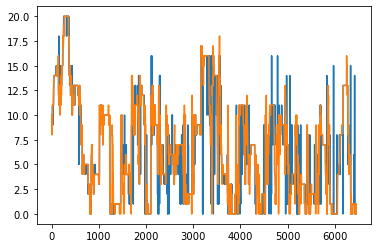

In [67]:
plt.plot(linreg_predictions)
plt.plot(y)

In [36]:
decisiontree.predict(Xtest[features])

array([9, 9, 9, ..., 0, 0, 0], dtype=int64)

# The following is the model we use

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [69]:
linreg = DecisionTreeRegressor().fit(X_train, y_train)

In [70]:
# Predicted price on training set
train_predictions = linreg.predict(X_train)
print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)], axis=1))
printMetrics(y_train, train_predictions)

Actual vs predicted on training:
       available_bikes  Predicted
1424                1   1.000000
435                10  10.000000
269                20  20.000000
3112                9   9.000000
817                 0   0.000000
...               ...        ...
4931                7   8.000000
3264               16  16.000000
1653                3   4.428571
2607                7   4.937500
2732                7   5.333333

[4519 rows x 2 columns]

MAE:  1.1360299504401354
RMSE:  1.9678433998354112
R2:  0.8319466062654172


In [71]:
test_predictions = linreg.predict(X_test)
print("Actual vs predicted on test:\n", pd.concat([y_test, pd.DataFrame(test_predictions, columns=['Predicted'], index=y_test.index)], axis=1))
printMetrics(y_test, test_predictions)

Actual vs predicted on test:
       available_bikes  Predicted
5435                8   3.166667
4215                6   3.750000
2232                9   9.000000
4584                5   5.250000
4312                5   1.739130
...               ...        ...
1085               10   7.333333
6285                9   7.066667
1005                3   3.000000
2048                0   1.000000
3753                1   0.000000

[1938 rows x 2 columns]

MAE:  1.3681749698565822
RMSE:  2.2610812645695453
R2:  0.7789132554781677


In [73]:
from sklearn import tree

[Text(404.04058319091797, 532.275, 'X[1] <= 31.0\nmse = 23.043\nsamples = 4519\nvalue = 6.788'),
 Text(300.8192888203605, 509.625, 'X[4] <= 0.5\nmse = 18.961\nsamples = 3626\nvalue = 6.024'),
 Text(186.50601616531122, 486.975, 'X[0] <= 275.5\nmse = 16.492\nsamples = 3096\nvalue = 5.522'),
 Text(74.8183094262295, 464.32500000000005, 'X[3] <= 0.5\nmse = 2.508\nsamples = 113\nvalue = 10.708'),
 Text(71.61667008196721, 441.675, 'X[2] <= 3.5\nmse = 0.968\nsamples = 78\nvalue = 11.513'),
 Text(70.15306352459017, 419.025, 'X[10] <= 0.5\nmse = 0.637\nsamples = 74\nvalue = 11.635'),
 Text(69.42126024590164, 396.375, 'X[2] <= 1.5\nmse = 0.582\nsamples = 71\nvalue = 11.577'),
 Text(68.68945696721312, 373.725, 'mse = 0.0\nsamples = 17\nvalue = 11.0'),
 Text(70.15306352459017, 373.725, 'X[2] <= 2.5\nmse = 0.627\nsamples = 54\nvalue = 11.759'),
 Text(68.68945696721312, 351.07500000000005, 'X[0] <= 273.5\nmse = 0.542\nsamples = 33\nvalue = 11.939'),
 Text(67.95765368852459, 328.425, 'mse = 0.0\nsampl

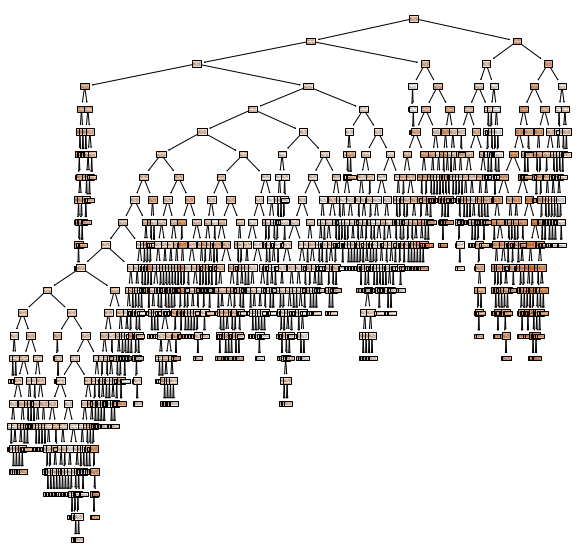

In [74]:
plt.figure(figsize=(10,10))
tree.plot_tree(linreg, filled=True)

In [75]:
# https://www.geeksforgeeks.org/saving-a-machine-learning-model/
import joblib
  
# Save the model as a pickle in a file
joblib.dump(linreg, 'station-2.pkl')
  
# Load the model from the file
decisiontree = joblib.load('station-2.pkl')

In [88]:
features

['temp',
 'humidity',
 'wind_speed',
 'dayquery_Friday',
 'dayquery_Monday',
 'dayquery_Saturday',
 'dayquery_Sunday',
 'dayquery_Thursday',
 'dayquery_Tuesday',
 'dayquery_Wednesday',
 'weather_main_Clear',
 'weather_main_Clouds',
 'weather_main_Drizzle',
 'weather_main_Fog',
 'weather_main_Mist',
 'weather_main_Rain']

In [101]:
engine = create_engine("mysql+pymysql://{0}:{1}@{2}".format(DB_USER, DB_PASS, DB_URL), echo=True) 
connection = engine.connect()

statement = """SELECT last_update, dayname(last_update) as dayquery, hour(last_update) as hourquery, temp, humidity, wind_speed, weather_main FROM dublin_bikes.weather_forecast_1hour
where station_number = 2
order by time_queried
limit 48;"""

2021-03-30 10:42:17,073 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-03-30 10:42:17,075 INFO sqlalchemy.engine.base.Engine {}
2021-03-30 10:42:17,278 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-03-30 10:42:17,280 INFO sqlalchemy.engine.base.Engine {}
2021-03-30 10:42:17,679 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-03-30 10:42:17,688 INFO sqlalchemy.engine.base.Engine {}
2021-03-30 10:42:18,015 INFO sqlalchemy.engine.base.Engine show collation where `Charset` = 'utf8mb4' and `Collation` = 'utf8mb4_bin'
2021-03-30 10:42:18,025 INFO sqlalchemy.engine.base.Engine {}
2021-03-30 10:42:18,152 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-03-30 10:42:18,163 INFO sqlalchemy.engine.base.Engine {}
2021-03-30 10:42:18,301 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-03-30 10:42:18,305 INFO sqlalchemy.engine.base.E

In [102]:
df_future = pd.read_sql_query(statement, engine) # https://stackoverflow.com/questions/29525808/sqlalchemy-orm-conversion-to-pandas-dataframe

2021-03-30 10:42:20,073 INFO sqlalchemy.engine.base.Engine SELECT last_update, dayname(last_update) as dayquery, hour(last_update) as hourquery, temp, humidity, wind_speed, weather_main FROM dublin_bikes.weather_forecast_1hour
where station_number = 2
order by time_queried
limit 48;
2021-03-30 10:42:20,082 INFO sqlalchemy.engine.base.Engine {}


In [103]:
categorical_columns = df_future[['dayquery', 'hourquery', 'weather_main','dayquery', 'hourquery']].columns
# Convert data type to category for these columns
for column in categorical_columns:
    df_future[column] = df_future[column].astype('category')  

df["humidity"] = df["humidity"].fillna(0)
df.dtypes

dayquery           category
hourquery          category
available_bikes       int64
temp                  int64
wind_speed            int64
pressure              int64
humidity            float64
weather_main       category
dtype: object

In [104]:
df_final_future = pd.get_dummies(df_future, drop_first=False)

In [105]:
df_final_future

,last_update,temp,humidity,wind_speed,dayquery_Friday,dayquery_Saturday,dayquery_Thursday,hourquery_0,hourquery_1,hourquery_2,...,hourquery_17,hourquery_18,hourquery_19,hourquery_20,hourquery_21,hourquery_22,hourquery_23,weather_main_Clear,weather_main_Clouds,weather_main_Rain
0,2021-02-27 05:00:00,280,94,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2021-02-26 18:00:00,280,85,3,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,2021-02-26 19:00:00,279,88,3,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,2021-02-26 20:00:00,279,90,3,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,2021-02-26 21:00:00,279,90,3,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,2021-02-26 22:00:00,279,90,3,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
6,2021-02-26 23:00:00,278,91,3,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7,2021-02-27 00:00:00,278,91,3,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8,2021-02-27 01:00:00,279,90,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9,2021-02-27 02:00:00,279,90,3,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [106]:
for col in features:
    if col not in df_final_future.columns:
        print(col)
        df_final_future[col] = [0 for i in range(len(df_final_future))]

dayquery_Monday
dayquery_Sunday
dayquery_Tuesday
dayquery_Wednesday
weather_main_Drizzle
weather_main_Fog
weather_main_Mist


In [112]:
result = decisiontree.predict(df_final_future[features])

In [124]:
final = pd.DataFrame(
    {'available_bikes': result.tolist(), 
     'time': df_final_future["last_update"].to_list()})

In [125]:
final

,available_bikes,time
0,18.857143,2021-02-27 05:00:00
1,10.000000,2021-02-26 18:00:00
2,20.000000,2021-02-26 19:00:00
3,20.000000,2021-02-26 20:00:00
4,20.000000,2021-02-26 21:00:00
5,20.000000,2021-02-26 22:00:00
6,14.500000,2021-02-26 23:00:00
7,20.000000,2021-02-27 00:00:00
8,18.857143,2021-02-27 01:00:00
9,20.000000,2021-02-27 02:00:00
